In [174]:
from prettyfigure.style import *

%matplotlib inline
from colossus.Cosmology import *
from colossus.HaloConcentration import *
from colossus.HaloDensityProfile import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import betainc

import cosmolopy as cp

from dmb.single_halo import *
from dmb.mass_func import *

define_figure_style()
setCosmology('planck15')
cosmo = getCurrent()

params = {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}

dm_data = np.genfromtxt('PPPC4DM/AtProductionNoEW_positrons.dat', names=True)
def get_electron_spec(e=5):
    '''
    Returns the electron energy specrum 
    '''
    return 10**dm_data['Log10x'][dm_data['mDM']==e], dm_data['q'][dm_data['mDM']==e]

In [175]:
def CLfit(z, params):
    if params == {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.2, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+6.3e5*z**-1.20*np.exp(-(z/45)**2.3)
    if params == {'logMcrit': -12, 'Ishiyama': True, 'c_scatter': 0.2, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+1.4e6*z**-1.3*np.exp(-(z/45)**2.3)
    
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.2, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+3.2e5*z**-1.18*np.exp(-(z/40)**2.3)
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+2.5e5*z**-1.18*np.exp(-(z/40)**2.3)
    if params == {'logMcrit': -9, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': True}:
        return 1.0+5.0e5*z**-1.25*np.exp(-(z/40)**2.3)
    
    if params == {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0.15, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+5.0e4*z**-1.14*np.exp(-(z/34)**2.2)
    if params == {'logMcrit': -6, 'Ishiyama': True, 'c_scatter': 0, 'cosmo': cosmo, 'subhalos': False}:
        return 1.0+3.5e4*z**-1.06*np.exp(-(z/32)**2.0)


In [176]:
z_list = np.logspace(0, np.log10(3000), 100)[::-1]
age_list = cp.distance.age(z_list, **cp.fidcosmo)

rho_eff = (1.0+z_list)**3 * np.sqrt(CLfit(z_list, params))*n_dm*mx
# plt.plot(z_list[:], rho_eff)
# plt.plot(z_list[:], (1+z_list)**3*n_dm*mx)
# plt.xscale('log')
# plt.yscale('log')

In [177]:
An_rate = rho_eff**2/mx**2/2*sigmav

Re_rate = (1.0+z_list)**6*n_b**2*3e-13

ion_per_ann = mx*1e9*0.3/13.6

# plt.plot(z_list, (Re_rate/(An_rate*ion_per_ann))**-0.5)
# # plt.plot(z_list, Re_rate)
# plt.xscale('log')
# plt.yscale('log')

In [178]:
adata = np.loadtxt('N20/A.txt', comments='#')
# bdata = np.loadtxt('N20/B.txt', comments='#')

z_list_model = np.linspace(0, 200, 10000)
x_HII_list = np.interp(z_list_model, 1./adata[::-1,0]-1.0, adata[::-1,9])
x_HeII_list = np.interp(z_list_model, 1./adata[::-1,0]-1.0, adata[::-1,11], left = 0)
x_HeIII_list = np.interp(z_list_model, 1./adata[::-1,0]-1.0, adata[::-1,12], left = 0)

x_HeIII_list[:249] = np.interp(z_list_model[:249],[0.0, 3.0, 5.0],[0.97,0.97,0.14])
x_HeII_list[:249] = 0.97-x_HeIII_list[:249]

# plt.plot(z_list_model, x_HII_list,'-',lw=1)
# plt.plot(z_list_model, x_HeII_list,'--')
# plt.plot(z_list_model, x_HeIII_list,'-.')
# # plt.xscale('log')
# # plt.yscale('log')
# plt.ylim([1e-4,1])
# plt.xlim([0,15])

# print cp.cr.integrate_optical_depth(np.array([1.0, 1.0]), 2.0*np.array([1.0, 1.0]), np.array([0.0, 5.0]), **cp.fidcosmo)[-1]

print cp.cr.integrate_optical_depth(x_HII_list, x_HeII_list+2.0*x_HeIII_list, z_list_model, **cp.fidcosmo)[-1]

0.058817941465


In [179]:
import radiator
from radiator.crosssections import *
cs = cross_sections(cs={'photion': 'VFKY1996', 'collion': 'AR', 'collex': 'SKD'})

In [180]:
# cosmo = Cosmology.setCosmology('planck13')
sigmaT = 6.6524e-25 #cm^2
me = 9.109e-28 # g
c = 2.9979e10 # cm/s
hbar = 1.0545e-27 # erg*s
kB = 1.380648e-16 # erg/K


In [181]:
z = z_list[0]
T_CMB = 2.7*(1+z)
CMBphotons = 8*np.pi*2*np.pi*hbar*nu_list**3/c**3/(np.exp(2.0*np.pi*hbar*nu_list/kB/T_CMB)-1.0)/Eg_list/(hbar*2*np.pi)
print 'number of photons per cm^3: ', np.trapz(CMBphotons, Eg_list)

number of photons per cm^3:  1.07975907573e+13


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [182]:
# Mass of dm particle in GeV
mx = 40
sigmav = 1e-26

# Mass of 1 GeV
g_in_GeV = 1.782e-24 

n_dm = AST_rho_crit_0_kpc3*cosmo.Om0/AST_kpc**3*AST_Msun*cosmo.h**2/mx/g_in_GeV
n_b = AST_rho_crit_0_kpc3*cosmo.Ob0/AST_kpc**3*AST_Msun*cosmo.h**2/1.672e-24
# 
print 'Number density of DM particles in a cm^3: ', n_dm
print '"Number density" of baryons in a cm^3:    ', n_b
x, y = get_electron_spec(e=mx)
# plt.plot(x, y)
# plt.yscale('log')
# plt.xscale('log')
print np.trapz(y*x*mx, np.log10(x))/mx
print np.sum(y*x*mx*np.gradient(np.log10(x)))/mx

e_add = np.interp(EgeV_list, x*mx*1e9, y*np.gradient(np.log10(x))/np.gradient(x), left=0, right=0)
# e_add *= np.gradient(EgeV_list)

e_add = e_add*np.gradient(EgeV_list)/1e9/mx

np.sum(e_add*EgeV_list)/1e9/mx

def ICon30CMB(EgeV_list, E0, z):
    return (1+z)**-0.5 * 3.8e-1 * (EgeV_list/1e9)**0.5 * \
           np.exp(\
               -(EgeV_list/1e9)*2.4e3* \
               (1.3e9/E0)**2. / \
               ((1.+z)/61)**1. \
               )

import cosmolopy as cp


Number density of DM particles in a cm^3:  3.73546225838e-08
"Number density" of baryons in a cm^3:     2.5054984114e-07
0.155386886471
0.155389061471


In [183]:
def evolve_phot(mx, sigmav, quite=True):
    Eg_list = np.logspace(-6, 15, 1000)/6.24e11
    nu_list = Eg_list / (hbar*2*np.pi)
    EgeV_list = Eg_list*6.24e11
    z_start = 200.0
    z_step = 0.01
    z_list = np.array([0])
    f = (Eg_list[1]/Eg_list[0])**1
    double_shift = int(np.ceil(np.log(2.0)/np.log(f)))
    for i in range(1000):
        z_list = np.append(z_list, f*(1.+z_list[-1])-1.0)
    z_list = z_list[z_list <= z_start]
    z_list = z_list[::-1]
    boost = CLfit(z_list, params)
    photon_history = np.zeros([len(EgeV_list), len(z_list)])

    age_list = cp.distance.age(z_list,**cp.fidcosmo)
    # DM things
    n_dm = AST_rho_crit_0_kpc3*cosmo.Om0/AST_kpc**3*AST_Msun*cosmo.h**2/mx/g_in_GeV
    n_b = AST_rho_crit_0_kpc3*cosmo.Ob0/AST_kpc**3*AST_Msun*cosmo.h**2/1.672e-24
    # 
    if not quite:
        print 'Number density of DM particles in a cm^3: ', n_dm
        print '"Number density" of baryons in a cm^3:    ', n_b
    x, y = get_electron_spec(e=mx)
    e_add = np.interp(EgeV_list, x*mx*1e9, y*np.gradient(np.log10(x))/np.gradient(x), left=0, right=0)
# e_add *= np.gradient(EgeV_list)
    e_add = e_add*np.gradient(EgeV_list)/1e9/mx
    # end DM things
    n_ion = np.zeros([len(z_list), 10])
    electronsN = np.zeros(len(EgeV_list))
    photons_particles = np.zeros(len(Eg_list))

    Sigma_photoion = cs.sigmaX(EgeV_list, 1, 1)
    Sigma_photoion_HeI = cs.sigmaX(EgeV_list, 2, 2)
    Sigma_photoion_HeII = cs.sigmaX(EgeV_list, 2, 1)

#     d_x_HII_d_z=np.interp(z, z_list_model, np.gradient(x_HII_list)/np.gradient(z_list_model))

    predicted_rhist = np.ones([len(z_list),10])*1e-8 # xHII, xHeII, xHeIII
    predicted_rhist[0, 0] = 2e-4

    for ii in range(len(z_list)-1):
        if not quite:
            print ii
        # time step
        dt = age_list[ii+1]-age_list[ii]
        tau = dt
        if not quite:
            print 'Time step [yrs]:', tau/3.14e7
        # current redshift
        z = 0.5 * (z_list[ii+1] + z_list[ii])
    #     print 'z=%5.1f'%z
        # CMB temperature
        T_CMB = 2.7*(1+z)
        # update CMB
        CMBphotons = 8*np.pi*2*np.pi*hbar*nu_list**3/c**3/(np.exp(2.0*np.pi*hbar*nu_list/kB/T_CMB)-1.0)/Eg_list/(hbar*2*np.pi)
    #     print 'number of photons per cm^3: ', np.trapz(CMBphotons, Eg_list)
        # add sources
    #     photons_particles += (phot2/(EgeV_list/1e9)**2*np.gradient(EgeV_list/1e9))*boost[ii]*(1.0+z)**3*tau
        electronsN += boost[ii]*(1.0+z)**6 * n_dm**2 * sigmav * tau * e_add
    #     print EgeV_list[800]
        if not quite:
            print np.sum(EgeV_list*photons_particles)
        photons_particles[:-1] = photons_particles[1:]
        photons_particles[:-1] = 0
        if not quite:
            print np.sum(EgeV_list*photons_particles)
        # add IC photons
        for i in range(len(electronsN)):
            photons_particles += electronsN[i] * ICon30CMB(EgeV_list, EgeV_list[i], z) * np.gradient(Eg_list) / Eg_list**2
        if not quite:
            print np.sum(EgeV_list*photons_particles), np.sum(EgeV_list*electronsN)
        electronsN *= 0
        # column density
        N_naked = n_b*c*tau*(1+z)**3
        N_H = N_naked*0.76*(1.0-predicted_rhist[ii, 0])
        N_HeI = N_naked*0.24/4*(1.0-predicted_rhist[ii, 1]-predicted_rhist[ii, 2])
        N_HeII = N_naked*0.24/4*(predicted_rhist[ii, 1])
        n_HI = (1.0 - predicted_rhist[ii, 0]) * 0.76 * n_b
        n_HII = predicted_rhist[ii, 0] * 0.76 * n_b
        n_HeI = (1.0-predicted_rhist[ii, 1]-predicted_rhist[ii, 2]) * 0.24/4 * n_b
        n_HeII = (predicted_rhist[ii, 1]) * 0.24/4 * n_b
        n_HeIII = (predicted_rhist[ii, 2]) * 0.24/4 * n_b
        n_e = 0.0 + n_HII+n_HeII+n_HeIII*2
        n_ion[ii,9] = (1.0+z)**3 * n_e * 4.2e-13 * tau
    #     N_O = N_naked*0.01/8
        # photoion
        temp_factor_H = (Sigma_photoion*N_H)
        temp_factor_He = (Sigma_photoion_HeI*N_HeI)
        temp_factor_HeII = (Sigma_photoion_HeII*N_HeII)
        temp_factor_H[EgeV_list < 13.6] = 0.0
        temp_factor_He[EgeV_list < 24.6] = 0.0
        temp_factor_HeII[EgeV_list < 40.2] = 0.0
        # temp_factor_O[EgeV_list < 13.6] = 0.0
        temp_factor = temp_factor_H + temp_factor_He + temp_factor_HeII # + temp_factor_O
        temp_factor_H[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
        temp_factor_He[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
        temp_factor_HeII[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
        # temp_factor_O[temp_factor > 1.0] /= temp_factor[temp_factor > 1.0]
        temp_factor[temp_factor > 1.0] = 1.0
        temp = photons_particles * temp_factor
        if not quite:
            print temp_factor_H.sum(), temp_factor_He.sum(), temp_factor_HeII.sum()
        d_x_HII = np.interp(z, z_list_model, np.gradient(x_HII_list)/np.gradient(z_list_model))*(z_list[ii]-z_list[ii+1])
        temp_H = photons_particles * temp_factor_H * (EgeV_list-13.6)
        temp_H[EgeV_list<13.6*2.5] = 0
        temp_He = photons_particles * temp_factor_He * (EgeV_list-24.4)
        temp_He[EgeV_list<24.4+13.6*2] = 0
        temp_HeII = photons_particles * temp_factor_HeII * (EgeV_list-40.2)
        temp_HeII[EgeV_list<40.2+13.6*2] = 0
        energy_in_electrons = np.sum(temp_H) + np.sum(temp_He) + np.sum(temp_HeII)
    #     print np.sum(temp_factor_H)
        n_ion[ii, 0] += np.sum(photons_particles * temp_factor_H) 
        n_ion[ii, 0] += (1-predicted_rhist[ii, 0])/3.0 * energy_in_electrons / 13.6
        n_ion[ii, 4] += np.sum(photons_particles * temp_factor_He)
        n_ion[ii, 8] += np.sum(photons_particles * temp_factor_HeII)
        # n_ion[ii, 8] += np.sum(photons_particles * temp_factor_O)
        if not quite:
            print np.sum(temp*EgeV_list) / np.sum(photons_particles*EgeV_list)
        photons_particles -= temp
    #     n_ion[ii,8] = 0.93*3.14e7*1e9*((1.+z)/7.)**-3
    #     print tau/3.14e7, n_ion[ii,8]/3.14e7
    #     predicted_rhist[ii+1, 0] = np.max([predicted_rhist[ii, 0], np.sum(n_ion[:ii+1,0])])
        predicted_rhist[ii+1, 0] = predicted_rhist[ii, 0] - \
                                   (1+z)**3 * n_e * predicted_rhist[ii, 0] * 4.2e-13 * dt + \
                                   n_ion[ii,0] / (1+z)**3 / n_HI
        predicted_rhist[ii+1, 0] = np.max([predicted_rhist[ii+1, 0], np.interp(z_list[ii+1], z_list_model, x_HII_list)])
        predicted_rhist[ii+1, 0] = np.min([predicted_rhist[ii+1, 0], 1.0])
        predicted_rhist[ii+1, 1] = predicted_rhist[ii, 1] - \
                                   (1+z)**3 * n_e * predicted_rhist[ii, 1] * 6 * 4.2e-13 * dt + \
                                   n_ion[ii,4] / (1+z)**3 / n_HeI
        predicted_rhist[ii+1, 1] = np.max([predicted_rhist[ii+1, 1], np.interp(z_list[ii+1], z_list_model, x_HeII_list)])
        predicted_rhist[ii+1, 1] = np.min([predicted_rhist[ii+1, 1], 1.0])
        predicted_rhist[ii+1, 2] = predicted_rhist[ii, 2] - \
                                   (1+z)**3 * n_e * predicted_rhist[ii, 2] * 6 * 4.2e-13 * dt + \
                                   n_ion[ii,8] / (1+z)**3 / n_HeII
        predicted_rhist[ii+1, 2] = np.max([predicted_rhist[ii+1, 2], np.interp(z_list[ii+1], z_list_model, x_HeIII_list)])
        predicted_rhist[ii+1, 2] = np.min([predicted_rhist[ii+1, 2], 1.0])
        if not quite:
            print z, np.sum(photons_particles * temp_factor_H)*13.6/(boost[ii]*(1.0+z)**6 * n_dm**2 * sigmav * mx*1e9 / 4.0 * tau)
        photon_history[:,ii] = photons_particles
    return z_list, predicted_rhist, photon_history

In [184]:
z_list, predicted_rhist, photon_history = evolve_phot(40, 1e-26, quite=False)

Number density of DM particles in a cm^3:  3.73546225838e-08
"Number density" of baryons in a cm^3:     2.5054984114e-07
0
Time step [yrs]: 490771.475034
0.0
0.0
5.5017714941e-05 6.50885595792e-05
119.608237403 240.514606656 2.15873054045e-06
0.991558034624
189.94485139 8.75275969779e-13
1
Time step [yrs]: 527728.842676
4.64457644591e-07
0.0
4.42494542695e-05 5.23492004606e-05
119.487420152 240.206606818 2.55647998835e-05
0.991428893907
180.922716182 8.45795077354e-13
2
Time step [yrs]: 567469.268801
3.79266767103e-07
0.0
3.55887952397e-05 4.21032327931e-05
119.368850759 239.903837666 4.75176482013e-05
0.99129362243
172.326876437 8.13622324145e-13
3
Time step [yrs]: 610202.329766
3.09849488628e-07
0.0
2.8623230739e-05 3.3862641426e-05
119.245228417 239.588151992 6.81188359786e-05
0.991149128821
164.137189714 7.92875111657e-13
4
Time step [yrs]: 656153.383781
2.53340528006e-07
0.0
2.30209914162e-05 2.7234927731e-05
119.130263773 239.294573745 8.74749020117e-05
0.991001385152
156.3344653

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in power
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:57: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:125: RuntimeWarning: invalid value encountered in double_scalars


 2.11696435679e-07
0.0 -1.08371978239e+22 1.57378626827e+21
-1.47215413656e+19
2.9739854339 0.0
81
Time step [yrs]: 171587604.13
2.63426415664e+12
0.0
1.55599728248e-07 1.84084191933e-07
nan -1.0677344416e+22 1.45891928078e+21
nan
2.78621480989 nan
82
Time step [yrs]: 183835459.079
nan
nan
nan 1.60210067168e-07
nan nan nan
nan
2.607316339 nan
83
Time step [yrs]: 196851558.672
nan
nan
nan 1.39559350933e-07
nan nan nan
nan
2.4368708124 nan
84
Time step [yrs]: 210660262.881
nan
nan
nan 1.21689158149e-07
nan nan nan
nan
2.27447882888 nan
85
Time step [yrs]: 225281186.941
nan
nan
nan 1.0621844086e-07
nan nan nan
nan
2.11975985891 nan
86
Time step [yrs]: 240727824.166
nan
nan
nan 9.28193866722e-08
nan nan nan
nan
1.97235135296 nan
87
Time step [yrs]: 257006011.223
nan
nan
nan 8.12100168721e-08
nan nan nan
nan
1.83190789196 nan
88
Time step [yrs]: 274112264.394
nan
nan
nan 7.11478219475e-08
nan nan nan
nan
1.69810037785 nan
89
Time step [yrs]: 292032035.968
nan
nan
nan 6.24242942167e-08
nan n

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:97: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:98: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:99: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:101: RuntimeWarning: invalid value encountered in greater


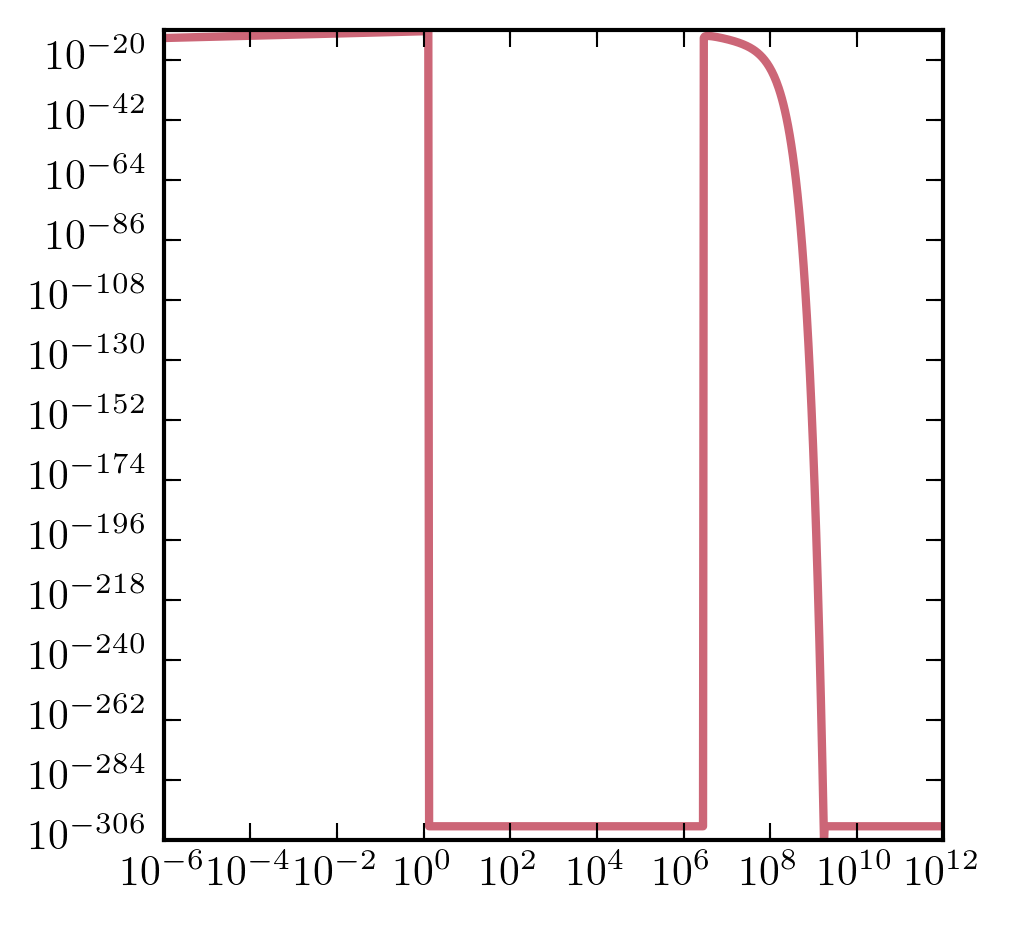

In [185]:
plt.plot(EgeV_list, photon_history[:,5]*EgeV_list)
# plt.plot(EgeV_list, Sigma_photoion_HeII)

plt.yscale('log')
plt.xscale('log')

0.0018138982173


(1, 150)

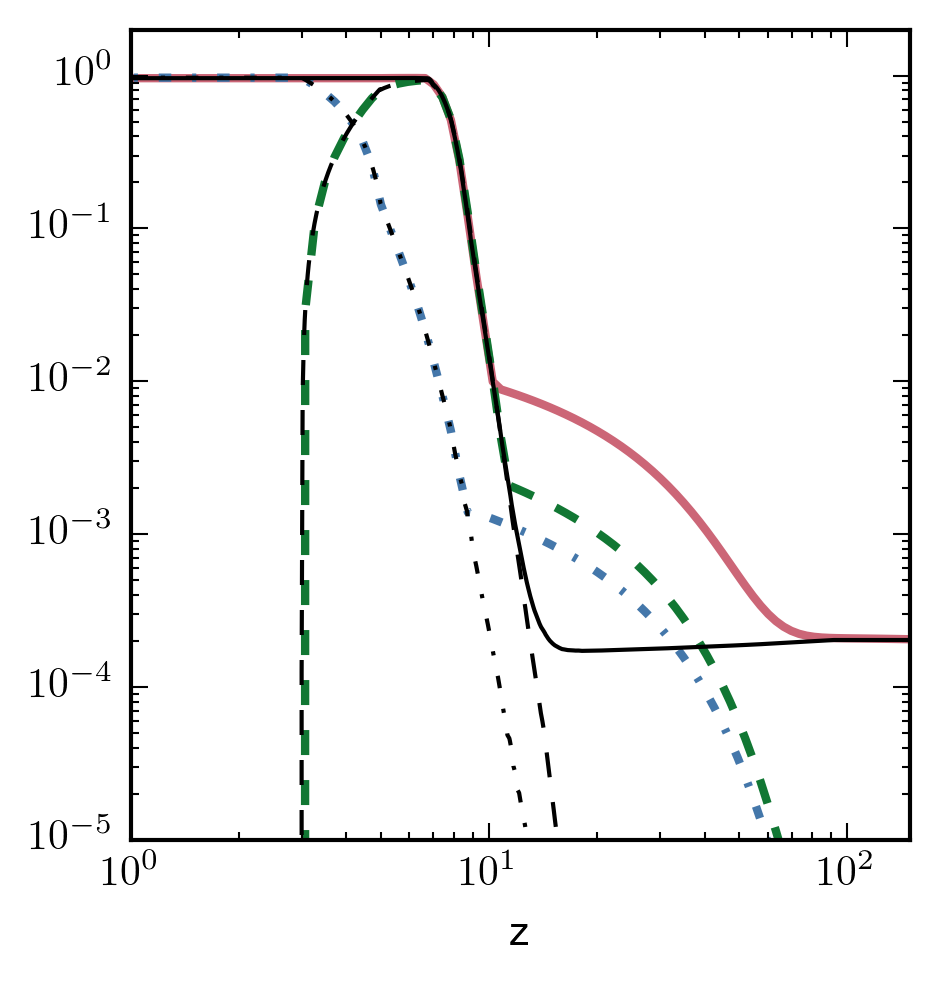

In [186]:
predicted_rhist[z_list<5,0] = np.interp(z_list, z_list_model, x_HII_list)[z_list<5]
predicted_rhist[z_list<5,1] = np.interp(z_list, z_list_model, x_HeII_list)[z_list<5]
predicted_rhist[z_list<5,2] = np.interp(z_list, z_list_model, x_HeIII_list)[z_list<5]
predicted_rhist[:,3] = np.interp(z_list, z_list_model, x_HII_list)
predicted_rhist[:,4] = np.interp(z_list, z_list_model, x_HeII_list)
predicted_rhist[:,5] = np.interp(z_list, z_list_model, x_HeIII_list)

plt.plot(z_list, predicted_rhist[:,0])
plt.plot(z_list, predicted_rhist[:,1],'--')
plt.plot(z_list, predicted_rhist[:,2],'-.')

tau_original = cp.cr.integrate_optical_depth(predicted_rhist[:,3], predicted_rhist[:,4]+2.0*predicted_rhist[:,5], z_list, **cp.fidcosmo)[-1]
tau_mod = cp.cr.integrate_optical_depth(predicted_rhist[:,0], predicted_rhist[:,1]+2.0*predicted_rhist[:,2], z_list, **cp.fidcosmo)[-1]
print tau_mod-tau_original

# print predicted_rhist
plt.plot(z_list_model, x_HII_list,'-k',lw=1)
plt.plot(z_list_model, x_HeII_list,'--k',lw=1)
plt.plot(z_list_model, x_HeIII_list,'-.k',lw=1)

plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-5, 2e0])
plt.xlabel('z')
# plt.ylim([1e-4,1e-3])
plt.xlim([1,150])


In [187]:
def tau_diff(mx, sigmav):
    z_list, predicted_rhist, dumb = evolve_phot(mx, sigmav)
    predicted_rhist[z_list<5,0] = np.interp(z_list, z_list_model, x_HII_list)[z_list<5]
    predicted_rhist[z_list<5,1] = np.interp(z_list, z_list_model, x_HeII_list)[z_list<5]
    predicted_rhist[z_list<5,2] = np.interp(z_list, z_list_model, x_HeIII_list)[z_list<5]
    predicted_rhist[:,3] = np.interp(z_list, z_list_model, x_HII_list)
    predicted_rhist[:,4] = np.interp(z_list, z_list_model, x_HeII_list)
    predicted_rhist[:,5] = np.interp(z_list, z_list_model, x_HeIII_list)
    tau_original = cp.cr.integrate_optical_depth(predicted_rhist[:,3], predicted_rhist[:,4]+2.0*predicted_rhist[:,5], z_list, **cp.fidcosmo)[-1]
    tau_mod = cp.cr.integrate_optical_depth(predicted_rhist[:,0], predicted_rhist[:,1]+2.0*predicted_rhist[:,2], z_list, **cp.fidcosmo)[-1]
    return tau_mod-tau_original

In [188]:
tau_diff(5, 1e-25)

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in power
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:57: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:125: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:97: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:98: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:99: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:101: RuntimeWarning: invalid value encountered in greater


nan

In [189]:
mx_list = np.sort(list(set(dm_data['mDM'])))[::5]
sigmav_list = np.logspace(-28, -23, 15)
tau_map = np.zeros([len(mx_list), len(sigmav_list)])

In [190]:
for i in range(len(mx_list))[::-1]:
    for j in range(len(sigmav_list)):
        print i,j
        tau_map[i,j]=tau_diff(mx_list[i], sigmav_list[j])

C:\Anaconda\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in power
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:57: RuntimeWarning: overflow encountered in exp
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:125: RuntimeWarning: invalid value encountered in double_scalars


12 0
12 1
12 2
12 3
12 4
12 5
12 6
12 7
12 8
12 9
12 10
12 11
12 12
12 13
12 14
11 0
11 1
11 2
11 3
11 4
11 5
11 6
11 7
11 8
11 9
11 10
11 11
11 12
11 13
11 14
10 0
10 1
10 2
10 3
10 4
10 5
10 6
10 7
10 8
10 9
10 10
10 11
10 12
10 13
10 14
9 0
9 1
9 2
9 3
9 4
9 5
9 6
9 7
9 8
9 9
9 10
9 11
9 12
9 13
9 14
8 0
8 1
8 2
8 3
8 4
8 5
8 6
8 7
8 8
8 9
8 10
8 11
8 12
8 13
8 14
7 0
7 1
7 2
7 3
7 4
7 5
7 6
7 7
7 8
7 9
7 10
7 11
7 12
7 13
7 14
6 0
6 1
6 2
6 3
6 4
6 5
6 6
6 7
6 8
6 9
6 10
6 11
6 12
6 13
6 14
5 0
5 1
5 2
5 3
5 4
5 5
5 6
5 7
5 8
5 9
5 10
5 11
5 12
5 13
5 14
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14


C:\Anaconda\lib\site-packages\ipykernel\__main__.py:97: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:98: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:99: RuntimeWarning: invalid value encountered in greater
C:\Anaconda\lib\site-packages\ipykernel\__main__.py:101: RuntimeWarning: invalid value encountered in greater


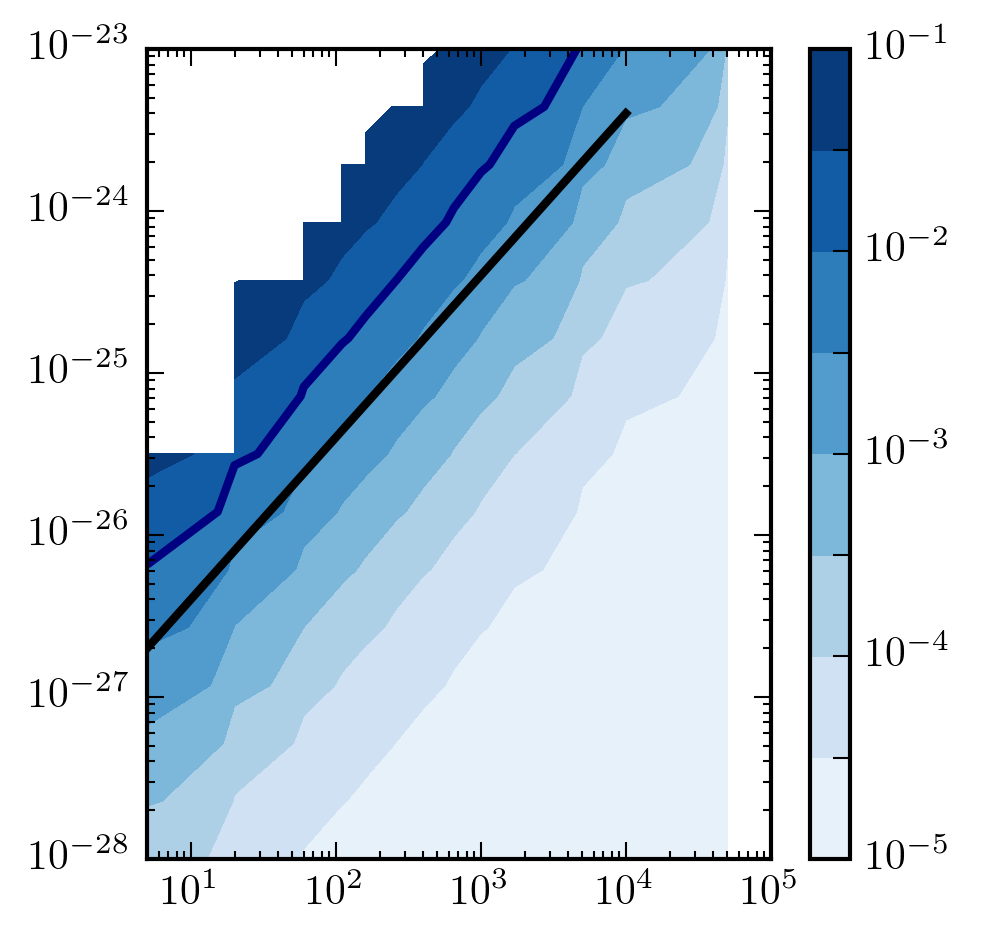

In [192]:
from matplotlib.colors import LogNorm

plt.contourf(mx_list, sigmav_list, tau_map.T, levels=np.logspace(-5,-1,9), interpolation='nearest', norm=LogNorm(),cmap='Blues')
plt.colorbar()
plt.contour(mx_list, sigmav_list, tau_map.T, levels=[0.01], interpolation='nearest', norm=LogNorm())
plt.plot([0.5, 1e4], [2e-28, 4e-24], 'k')
plt.xlim([5, 1e5])
plt.xscale('log')
plt.yscale('log')

![Plank dm](http://2.bp.blogspot.com/-Y9UO7uQOE68/VHzDeWlgV2I/AAAAAAAABgk/FtQ8qd8HeNo/s1600/Planck_DMlimits.png)

In [ ]:
temp=z_list.copy()*0
for ii in range(len(z_list)-1):
    print ii
    # time step
    dt = age_list[ii+1]-age_list[ii]
    tau = dt
    print 'Time step [yrs]:', tau/3.14e7, temp[ii]
    # current redshift
    z = 0.5 * (z_list[ii+1] + z_list[ii])
    temp[ii+1] = temp[ii] + \
                 (boost[ii] * (1.0+z)**6 * n_dm**2 * sigmav * mx*1e9 * tau / 13.6)/n_b/(1+z)**3

In [ ]:
plt.plot(z_list, temp)
plt.yscale('log')
plt.xscale('log')
# plt.ylim([1e-5, 2e0])
# plt.ylim([1e-4,1e-3])
plt.xlim([1,300])

In [127]:
np.sort(list(set(dm_data['mDM'])))

array([  5.00000000e+00,   6.00000000e+00,   8.00000000e+00,
         1.00000000e+01,   1.50000000e+01,   2.00000000e+01,
         2.50000000e+01,   3.00000000e+01,   4.00000000e+01,
         5.00000000e+01,   6.00000000e+01,   7.00000000e+01,
         8.00000000e+01,   9.00000000e+01,   1.00000000e+02,
         1.10000000e+02,   1.20000000e+02,   1.30000000e+02,
         1.40000000e+02,   1.50000000e+02,   1.60000000e+02,
         1.80000000e+02,   2.00000000e+02,   2.20000000e+02,
         2.40000000e+02,   2.60000000e+02,   2.80000000e+02,
         3.00000000e+02,   3.30000000e+02,   3.60000000e+02,
         4.00000000e+02,   4.50000000e+02,   5.00000000e+02,
         5.50000000e+02,   6.00000000e+02,   6.50000000e+02,
         7.00000000e+02,   7.50000000e+02,   8.00000000e+02,
         9.00000000e+02,   1.00000000e+03,   1.10000000e+03,
         1.20000000e+03,   1.30000000e+03,   1.50000000e+03,
         1.70000000e+03,   2.00000000e+03,   2.50000000e+03,
         3.00000000e+03,